<a href="https://colab.research.google.com/github/lexxai/goit_python_ds_hw_05/blob/main/goit_ds_hw_05_extra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LOAD DATASET

In [30]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.tree import plot_tree

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
from pathlib import Path

DATASET_KEYS = ("f0s0", "f0s1", "f1s0", "f1s1")
SAVED_DATAFRAME_BASE = Path("/content/")
URL = "https://drive.usercontent.google.com/download?id=1nzrtQpfaHL0OgJ_eXzA7VuEj7XotrSWO&export=download&authuser=0"
OUTPUT = Path("/content/homework.zip")
CSV_DATA_PATH  = Path("/content/data")

In [3]:
if not OUTPUT.is_file():
  !wget -O $OUTPUT $URL

if OUTPUT.is_file() and not CSV_DATA_PATH.is_dir():
  !unzip -q -o $OUTPUT
  #!rm $OUTPUT

In [4]:
if CSV_DATA_PATH.is_dir():
  class_path = sorted(CSV_DATA_PATH.iterdir())
  class_list = list(d.name for d in class_path)
  print(class_list)

['idle', 'running', 'stairs', 'walking']


### PRELOAD SAVED DATASETs

In [5]:
def gen_saved_name(key):
  return SAVED_DATAFRAME_BASE.joinpath(f"data-{key}.father")

In [6]:
df_set = {}
X_set = {}
y_set = {}
reports = {}

In [7]:
skip_load = False

In [8]:
for key in DATASET_KEYS:
  filename = gen_saved_name(key)
  if not skip_load and filename.is_file():
    df_set[key] = pd.read_feather(filename)
    X_set[key] = df_set[key].iloc[:,:-1]
    y_set[key] = df_set[key].iloc[:,-1]
    print(f"DATASET {key}. Loaded. shape: {df_set[key].shape}")
  else:
    df_set[key] = pd.DataFrame()

DATASET f0s0. Loaded. shape: (193860, 4)
DATASET f0s1. Loaded. shape: (193860, 31)
DATASET f1s0. Loaded. shape: (6462, 91)
DATASET f1s1. Loaded. shape: (6462, 118)


## BUILD DataFrame

#### functions

In [9]:
def save_dataset(key,df):
  filename = gen_saved_name(key)
  if not df.empty and not filename.is_file():
    df.to_feather(filename)

In [10]:
def flatten_frame(frame):
        columns=[f"{col}_{i}" for i in range(frame.shape[0]) for col in frame.columns]
        return pd.DataFrame(frame.values.reshape(1, -1), columns=columns)

In [11]:
def add_stat_feature_frame(frame, rows):
  features = []
  for col_id in range(0,3):
    col = frame.iloc[:,col_id]
    features.append(pd.DataFrame([col.mean()] * rows,columns=[f'{col.name}_mean']))
    features.append(pd.DataFrame([col.max()] * rows,columns=[f'{col.name}_max']))
    features.append(pd.DataFrame([col.min()] * rows,columns=[f'{col.name}_min']))
    features.append(pd.DataFrame([col.quantile(0.75)-col.quantile(0.25)] * rows,columns=[f'{col.name}_interquartile_range']))
    features.append(pd.DataFrame([col.idxmin()] * rows,columns=[f'{col.name}_index_of_minimum_value']))
    features.append(pd.DataFrame([np.mean(np.abs(col - col.mean()))] * rows,columns=[f'{col.name}_mean_of_absolute_deviation']))
    features.append(pd.DataFrame([col.median()] * rows,columns=[f'{col.name}_median']))
    # features.append(pd.DataFrame([df.skew(axis=0).iloc[:,col_id]] * rows,columns=[f'{col.name}_skewness']))
    features.append(pd.DataFrame([col.std()] * rows,columns=[f'{col.name}_standard_deviation']))
    features.append(pd.DataFrame([np.sqrt(np.mean(col)**2)] * rows,columns=[f'{col.name}_root_mean_square_error']))

  result = pd.concat(features, axis=1)
  # rint(f"New stats features: {result.columns}")
  return result

In [12]:
def prepare_dataset(class_path: list[Path], flatten = True, stat_feature = True, limit_frames = None):
  dfws = []
  for class_id, work_class_path in enumerate(class_path):
    list_files = list(sorted(work_class_path.glob('*.csv'), key=lambda path: int(path.stem.rsplit("-", 1)[1])))
    print(f"- Importing class '{work_class_path.name:7}' : {class_id}. Frames: {len(list_files)}")
    for i, filename in enumerate(list_files):
      # READ FRAME CSV FILE
      df_w: pd.DataFrame = pd.read_csv(filename)
      addon_features = [df_w]
      if flatten:
        addon_features = [flatten_frame(df_w)]
      if stat_feature:
        addon_features.append(add_stat_feature_frame(df_w,addon_features[0].shape[0]))
      df_w = pd.concat(addon_features, axis=1)
      df_w['class'] = class_id
      dfws.append(df_w)
      if limit_frames and (i > limit_frames):
        break
  df = pd.concat(dfws, axis=0, ignore_index=True)
  # print(df.info())
  print(df.shape)
  return df

### DATASETs  (f0s0, f0s1, f1s0, f1s1)

In [13]:
limit_frames = None
for f in range(2):
  for s in range(2):
    key_set = f"f{f}s{s}"
    print(f"\nDATASET {key_set}. Where flatten={bool(f)}, stat_feature={bool(s)}")
    if df_set.get(key_set) is not None and (not df_set[key_set].empty):
      print("Alredy loaded, skipped")
      continue
    df_set[key_set] = prepare_dataset(class_path, flatten = f, stat_feature = s, limit_frames = limit_frames)
    save_dataset(key_set, df_set[key_set])
    # print(df_set[key_set].sample(4))
    X_set[key_set] = df_set[key_set].iloc[:,:-1]
    y_set[key_set] = df_set[key_set].iloc[:,-1]


DATASET f0s0. Where flatten=False, stat_feature=False
Alredy loaded, skipped

DATASET f0s1. Where flatten=False, stat_feature=True
Alredy loaded, skipped

DATASET f1s0. Where flatten=True, stat_feature=False
Alredy loaded, skipped

DATASET f1s1. Where flatten=True, stat_feature=True
Alredy loaded, skipped


## Незбаланосваність класів

In [14]:
key_set = list(df_set.keys())[0]
total = df_set[key_set].shape[0]
df_t = df_set[key_set]['class'].value_counts().to_dict()
for x in sorted(df_t.keys()):
  count = df_t[x]
  prop = count / total
  print(f"class: {x}, rows: {count:7}, {class_list[x]:7}, prop: {prop:.4}" )

class: 0, rows:   31170, idle   , prop: 0.1608
class: 1, rows:  102240, running, prop: 0.5274
class: 2, rows:    4950, stairs , prop: 0.02553
class: 3, rows:   55500, walking, prop: 0.2863


In [15]:
# key_set = list(df_set.keys())[0]
# for x in df_set[key_set]['class'].unique():
#   count = df_set[key_set]['class'][df_set[key_set]['class'] == x].count()
#   prop = count / df_set[key_set].shape[0]
#   print(f"class: {x}, rows: {count:7}, {class_list[x]:7}, prop: {prop:.4}" )

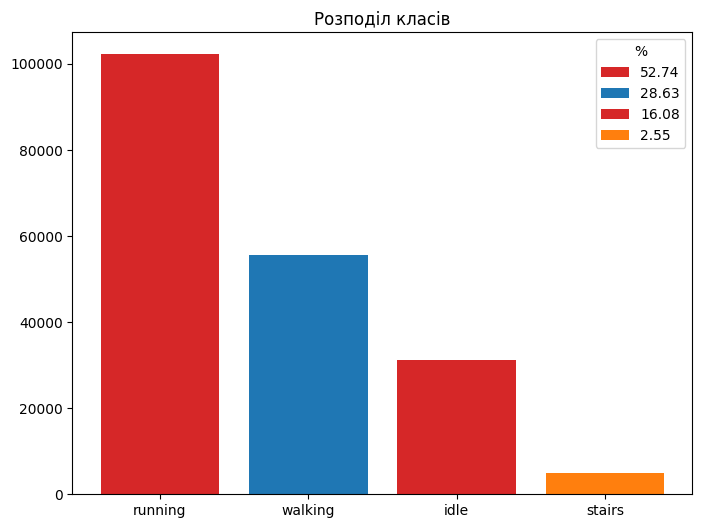

In [16]:
# Візуалізація розподілу класів
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
#sns.countplot(x='class', data=df_set[key_set])
bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']
df_t = df_set[key_set]['class'].value_counts()
plt.bar(x=df_t.index.map(lambda x: class_list[x]), height=df_t, color=bar_colors, label=(df_t/total*100).round(2) )
plt.title('Розподіл класів')
plt.legend(title='%')
plt.show()

## 3D plot



In [17]:
def plot_3d(df_t):
  xx = df_t.iloc[:,0]
  yy = df_t.iloc[:,1]
  zz = df_t.iloc[:,2]
  cc = df_t.iloc[:,3]
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(projection='3d')

  sc = ax.scatter(xx, yy, zz, c=cc, cmap='coolwarm', edgecolors='k')
  unique_categories = np.unique(cc)
  colors = plt.cm.coolwarm(np.linspace(0, 1, len(unique_categories)))
  #print(colors)
  for i,c in enumerate(unique_categories):
      ax.scatter([], [], [], color=colors[i], label=f'{class_list[c]}')
  ax.set_xlabel(df_set[key].columns[0])
  ax.set_ylabel(df_set[key].columns[1])
  ax.set_zlabel(df_set[key].columns[2])
  ax.set_title('Прискорення акселерометра (тривимірний простір)')
  ax.set_box_aspect([1, 1, 1])  # Set the aspect ratio to be 1:1:1
  ax.legend()
  plt.show()


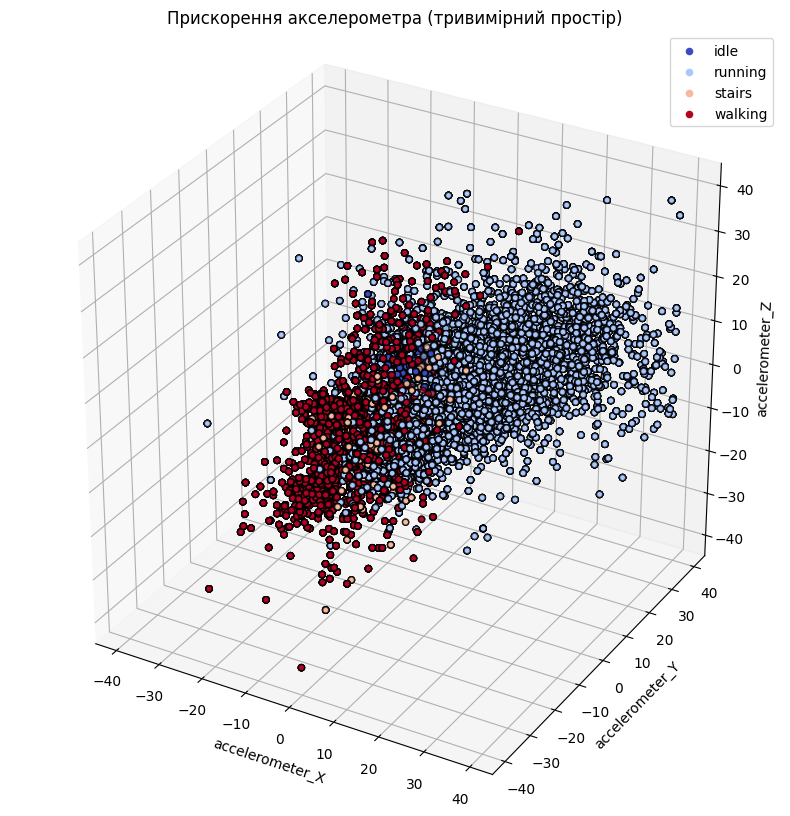

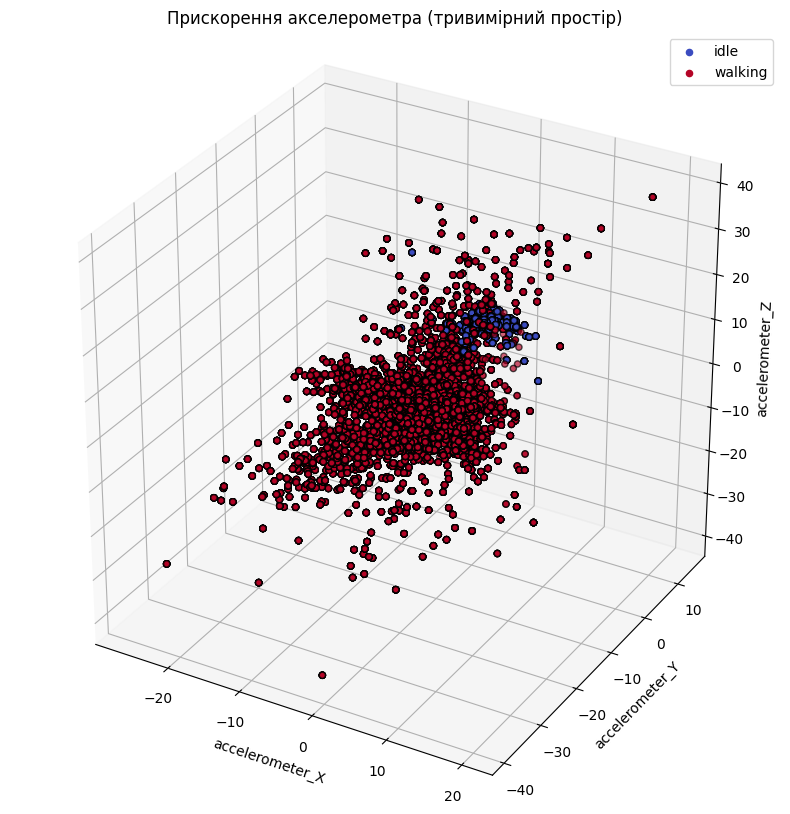

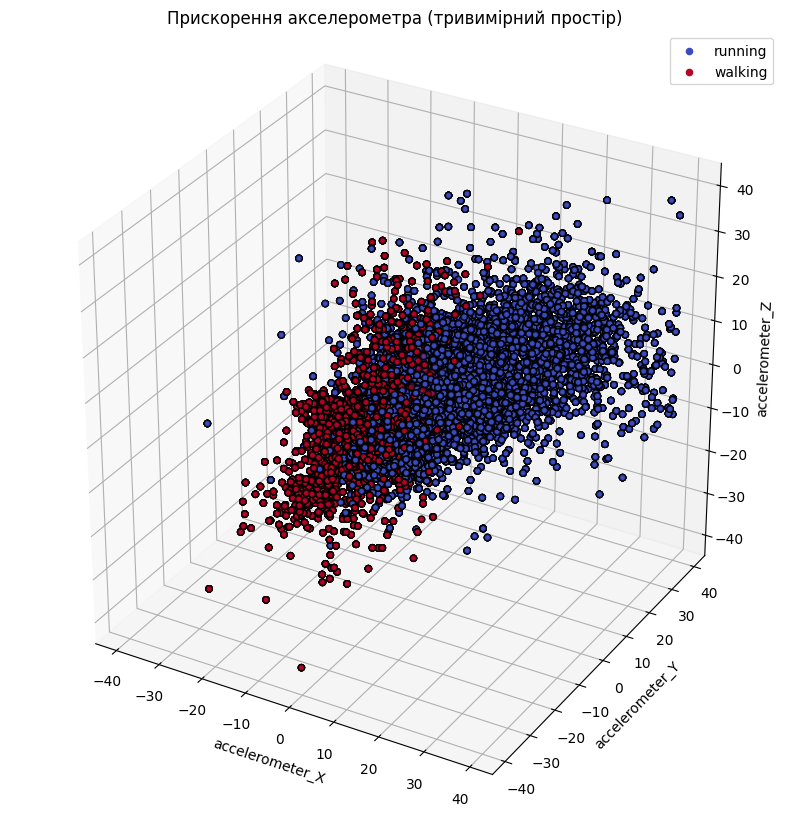

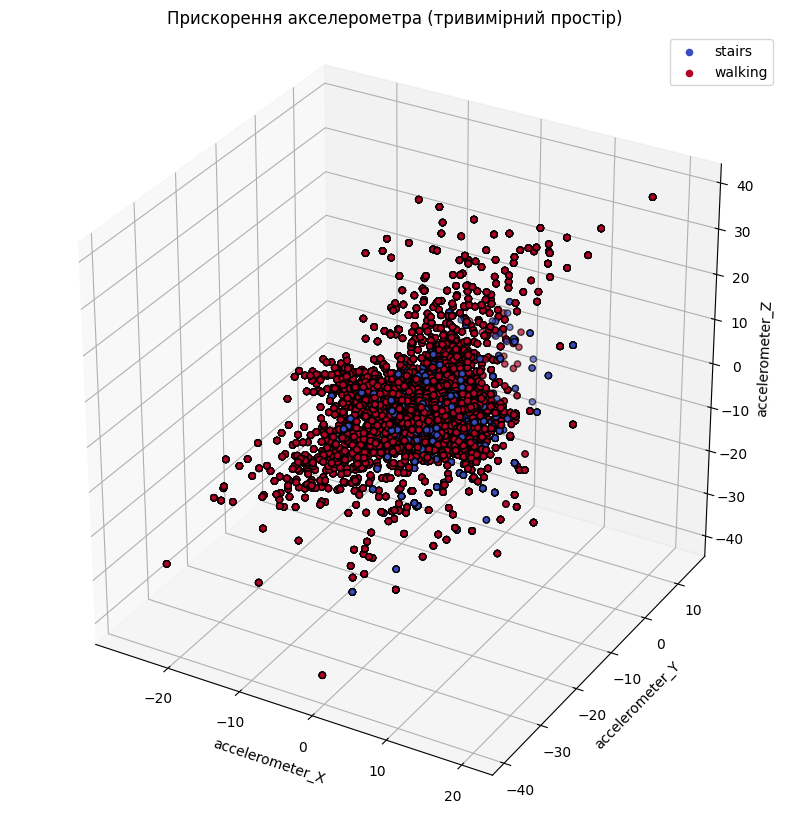

In [18]:
key = "f0s0"
actions_1 = [0,3]
actions_2 = [1,3]
actions_3 = [2,3]
df_t = df_set[key]
plot_3d(df_t)
plot_3d(df_t[df_t["class"].isin(actions_1)])
plot_3d(df_t[df_t["class"].isin(actions_2)])
plot_3d(df_t[df_t["class"].isin(actions_3)])
del df_t

## COMPARE MODELS

In [19]:
models = {"SVC": lambda: make_pipeline(StandardScaler(), SVC(gamma='auto', class_weight="balanced")),
          "SVC_Linear": lambda: make_pipeline(StandardScaler(), SVC(gamma='auto', kernel="linear", class_weight="balanced")),
          "RandomForestClassifier": lambda: RandomForestClassifier()}
reports = {}
skip_models = {
    "SVC_Linear": ["f0s0"]
}
skip_resample = ["f0s0"]

In [21]:
def balance_log(y):
  unique_values, counts = np.unique(y, return_counts=True)
  for x, count in zip(unique_values, counts):
      prop = count / y.shape[0]
      print(f"class: {x}, rows: {count:7}, {class_list[x]:7}, prop: {prop:.4}" )

In [22]:
SEED = 42
print("Models fit and prepare report")
for key in X_set.keys():
  print("-"*80)
  print(f"DATASET {key}. shape: {df_set[key].shape}")
  X = X_set[key]
  y = y_set[key]
  balance_log(y)
 # if key in skip_resample:
  if True:
     print("SKIP RESAMPLE")
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)
  else:
    # sm = SMOTE(random_state=0)
    # X_resampled, y_resampled = sm.fit_resample(X, y)
    rundersampler = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rundersampler.fit_resample(X, y)
    print(f"{X.shape=}")
    print(f"{X_resampled.shape=}")
    print(f"{y_resampled.shape=}")
    balance_log(y_resampled)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=SEED, stratify=y_resampled)
  if reports.get(key) is None:
    reports[key] = {}
  for model, classification in models.items():
    print(f"\n- classification: {model}")
    if reports[key].get(model):
      print("   alredy fit, skipped")
      continue
    if key in skip_models.get(model,[]):
      print("   skip this model")
      continue
    clf = classification()
    %time clf.fit(X_train, y_train)
    %time y_test_predict = clf.predict(X_test)
    reports[key][model] = classification_report(y_test, y_test_predict, digits=4, target_names=class_list)


Models fit and prepare report
--------------------------------------------------------------------------------
DATASET f0s0. shape: (193860, 4)
class: 0, rows:   31170, idle   , prop: 0.1608
class: 1, rows:  102240, running, prop: 0.5274
class: 2, rows:    4950, stairs , prop: 0.02553
class: 3, rows:   55500, walking, prop: 0.2863
SKIP RESAMPLE

- classification: SVC
CPU times: user 5min 41s, sys: 735 ms, total: 5min 41s
Wall time: 6min 2s
CPU times: user 2min 54s, sys: 412 ms, total: 2min 55s
Wall time: 3min 18s

- classification: SVC_Linear
   skip this model

- classification: RandomForestClassifier
CPU times: user 14.5 s, sys: 50.4 ms, total: 14.6 s
Wall time: 17.9 s
CPU times: user 853 ms, sys: 2 ms, total: 855 ms
Wall time: 896 ms
--------------------------------------------------------------------------------
DATASET f0s1. shape: (193860, 31)
class: 0, rows:   31170, idle   , prop: 0.1608
class: 1, rows:  102240, running, prop: 0.5274
class: 2, rows:    4950, stairs , prop: 0.02

## Classification report

In [37]:
print(f"{limit_frames=}")
for dset in reports.keys():
  for model in reports[dset].keys():
    print("-"*80)
    print(f"Data set: {dset}, shape: {df_set[dset].shape}, model: {model}")
    print(reports[dset][model])

limit_frames=None
--------------------------------------------------------------------------------
Data set: f0s0, shape: (193860, 4), model: SVC
              precision    recall  f1-score   support

        idle     0.9323    0.9925    0.9615      9351
     running     0.9764    0.7910    0.8740     30672
      stairs     0.1026    0.6990    0.1790      1485
     walking     0.8740    0.6951    0.7744     16650

    accuracy                         0.7936     58158
   macro avg     0.7213    0.7944    0.6972     58158
weighted avg     0.9177    0.7936    0.8418     58158

--------------------------------------------------------------------------------
Data set: f0s0, shape: (193860, 4), model: RandomForestClassifier
              precision    recall  f1-score   support

        idle     0.9996    1.0000    0.9998      9351
     running     0.9997    0.9999    0.9998     30672
      stairs     1.0000    0.9933    0.9966      1485
     walking     0.9998    0.9997    0.9997     16650



### OPTIMUM PARAMETERS OF TREE

In [ ]:
key_set = 'f0s1'
X_train, X_test, y_train, y_test = train_test_split(X_set[key_set], y_set[key_set], test_size=0.3, random_state=SEED, stratify=y_set[key_set])

In [36]:
pipeline_rf = Pipeline(steps=[('classifier', RandomForestClassifier(class_weight='balanced', random_state=SEED))])

param_dict_rf = {
    'classifier__n_estimators': [10, 25, 50, 75, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30,40,50],
    'classifier__min_samples_split': [2, 5, 10,20, 30],
    'classifier__min_samples_leaf': [1, 2, 4]
}

random_search_rf = RandomizedSearchCV(pipeline_rf,
                                   param_distributions=param_dict_rf,
                                   n_iter=10,
                                   scoring='roc_auc_ovr',
                                   cv=3,
                                   random_state=42)

random_search_rf.fit(X_train, y_train)
# Виведемо найкращі параметри та результати
print("Best Parameters: ", random_search_rf.best_params_)
print("Best Scoring: {:.2f}".format(random_search_rf.best_score_))

Best Parameters:  {'classifier__n_estimators': 25, 'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 20}
Best Scoring: 1.00


## RESULTS:

Different datasets were created from CSV source files downloaded from various folders, each named according to the related activity. And each file had 30 records of 3 accelerometer parameters (coordinates).


* Dataset f0s0: Contains data with 4 features.
* Dataset f0s1: Contains data with 31 features.
* Dataset f1s0: Contains data with 91 features.
* Dataset f1s1: Contains data with 118 features.

In the 'f0s0' dataset, the SVC-Linear model was skipped during the long-time operation, potentially exceeding one hour.

Additionally, the SVC model was augmented with StandardScaler(), resulting in a modest increase of 0.452% in accuracy.

The models used for analysis included SVC, SVC-Linear, and RandomForestClassifier.

* For the dataset with 4 features (f0s0), the RandomForestClassifier performs better.
* For the dataset with 31 features (f0s1), the RandomForestClassifier performs better.
* For the dataset with 91 features (f1s0), the RandomForestClassifier performs better.
* For the dataset with 118 features (f1s1), the RandomForestClassifier performs better.

This dataset 'f0s1' achieved a perfect accuracy of 1.0000, making it the highest among the provided datasets.

The dataset 'f0s1' has not been flattened and statistical features have been added.

Winner is datast 'f0s1' with with 31 features when using the RandomForestClassifier model.

Best Parameters of datast 'f0s1' with RandomForestClassifier model is :  
  - 'n_estimators': 25
  - 'min_samples_split': 20
  - 'min_samples_leaf': 2
  - 'max_depth': 20

Best Scoring: 1.00

## TEST на minimuм данних аккселерометра

In [ ]:
rows = 10
df_one = df_set['f0s0'].iloc[:rows,:3]
df_one_class = df_set['f0s0'].iloc[:rows,3]
df_one_class

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: class, dtype: int64

In [ ]:
df_one_stat = add_stat_feature_frame(df_one,df_one.shape[0])
df_one_stat

,accelerometer_X_mean,accelerometer_X_max,accelerometer_X_min,accelerometer_X_interquartile_range,accelerometer_X_index_of_minimum_value,accelerometer_X_mean_of_absolute_deviation,accelerometer_X_median,accelerometer_X_standard_deviation,accelerometer_X_root_mean_square_error,accelerometer_Y_mean,...,accelerometer_Y_root_mean_square_error,accelerometer_Z_mean,accelerometer_Z_max,accelerometer_Z_min,accelerometer_Z_interquartile_range,accelerometer_Z_index_of_minimum_value,accelerometer_Z_mean_of_absolute_deviation,accelerometer_Z_median,accelerometer_Z_standard_deviation,accelerometer_Z_root_mean_square_error
0,0.720176,5.09965,-0.909797,1.045069,2,1.140406,-0.059855,1.710087,0.720176,0.778594,...,0.778594,9.277053,9.787497,8.418014,1.039083,3,0.497994,9.507375,0.593041,9.277053
1,0.720176,5.09965,-0.909797,1.045069,2,1.140406,-0.059855,1.710087,0.720176,0.778594,...,0.778594,9.277053,9.787497,8.418014,1.039083,3,0.497994,9.507375,0.593041,9.277053
2,0.720176,5.09965,-0.909797,1.045069,2,1.140406,-0.059855,1.710087,0.720176,0.778594,...,0.778594,9.277053,9.787497,8.418014,1.039083,3,0.497994,9.507375,0.593041,9.277053
3,0.720176,5.09965,-0.909797,1.045069,2,1.140406,-0.059855,1.710087,0.720176,0.778594,...,0.778594,9.277053,9.787497,8.418014,1.039083,3,0.497994,9.507375,0.593041,9.277053
4,0.720176,5.09965,-0.909797,1.045069,2,1.140406,-0.059855,1.710087,0.720176,0.778594,...,0.778594,9.277053,9.787497,8.418014,1.039083,3,0.497994,9.507375,0.593041,9.277053
5,0.720176,5.09965,-0.909797,1.045069,2,1.140406,-0.059855,1.710087,0.720176,0.778594,...,0.778594,9.277053,9.787497,8.418014,1.039083,3,0.497994,9.507375,0.593041,9.277053
6,0.720176,5.09965,-0.909797,1.045069,2,1.140406,-0.059855,1.710087,0.720176,0.778594,...,0.778594,9.277053,9.787497,8.418014,1.039083,3,0.497994,9.507375,0.593041,9.277053
7,0.720176,5.09965,-0.909797,1.045069,2,1.140406,-0.059855,1.710087,0.720176,0.778594,...,0.778594,9.277053,9.787497,8.418014,1.039083,3,0.497994,9.507375,0.593041,9.277053
8,0.720176,5.09965,-0.909797,1.045069,2,1.140406,-0.059855,1.710087,0.720176,0.778594,...,0.778594,9.277053,9.787497,8.418014,1.039083,3,0.497994,9.507375,0.593041,9.277053
9,0.720176,5.09965,-0.909797,1.045069,2,1.140406,-0.059855,1.710087,0.720176,0.778594,...,0.778594,9.277053,9.787497,8.418014,1.039083,3,0.497994,9.507375,0.593041,9.277053


In [ ]:
X_test_one = pd.concat([df_one, df_one_stat], axis=1)
X_test_one.fillna(0, inplace=True)
X_test_one[:1]

,accelerometer_X,accelerometer_Y,accelerometer_Z,accelerometer_X_mean,accelerometer_X_max,accelerometer_X_min,accelerometer_X_interquartile_range,accelerometer_X_index_of_minimum_value,accelerometer_X_mean_of_absolute_deviation,accelerometer_X_median,...,accelerometer_Y_root_mean_square_error,accelerometer_Z_mean,accelerometer_Z_max,accelerometer_Z_min,accelerometer_Z_interquartile_range,accelerometer_Z_index_of_minimum_value,accelerometer_Z_mean_of_absolute_deviation,accelerometer_Z_median,accelerometer_Z_standard_deviation,accelerometer_Z_root_mean_square_error
0,1.000776,4.616021,8.576031,0.720176,5.09965,-0.909797,1.045069,2,1.140406,-0.059855,...,0.778594,9.277053,9.787497,8.418014,1.039083,3,0.497994,9.507375,0.593041,9.277053


In [ ]:
key = 'f0s1'
X = X_set[key]
y = y_set[key]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)
# clf = SVC(kernel="linear")
clf = RandomForestClassifier()
%time clf.fit(X_train, y_train)

CPU times: user 15.4 s, sys: 25.4 ms, total: 15.4 s
Wall time: 15.5 s


RandomForestClassifier()

In [ ]:
y_test_predict_one = clf.predict(X_test_one[:1])
y_test_predict_one

array([0])

In [ ]:
print(classification_report(df_one_class[:y_test_predict_one.shape[0]], y_test_predict_one, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         1

    accuracy                         1.0000         1
   macro avg     1.0000    1.0000    1.0000         1
weighted avg     1.0000    1.0000    1.0000         1



тести показали мінімум 10 записів акселерометра треба для формування (статистики),
 щоб прогноз сходився